Loaded 5961 satellites
STARLINK-1162 catalog #45058 epoch 2024-05-15 14:00:01 UTC at Azimuth: 320.7383428536666°, Altitude: 33.80242475712834°, Distance: 912.4753211634059 km
STARLINK-1152 catalog #45096 epoch 2024-05-15 20:39:20 UTC at Azimuth: 152.59837888436272°, Altitude: 30.411513637306765°, Distance: 982.3174861138377 km
STARLINK-1637 catalog #46133 epoch 2024-05-15 20:45:59 UTC at Azimuth: 337.55839461868106°, Altitude: 42.96778018381666°, Distance: 776.0193391967691 km
STARLINK-1643 catalog #46136 epoch 2024-05-15 17:41:33 UTC at Azimuth: 302.1794634877703°, Altitude: 42.42661018323418°, Distance: 781.3418803340254 km
STARLINK-1545 catalog #46156 epoch 2024-05-15 03:17:42 UTC at Azimuth: 36.76634142868611°, Altitude: 34.84763083735121°, Distance: 897.5348973551535 km
STARLINK-1791 catalog #46692 epoch 2024-05-15 20:43:21 UTC at Azimuth: 291.7820588105276°, Altitude: 58.64745066846386°, Distance: 635.863375722238 km
STARLINK-1829 catalog #46726 epoch 2024-05-15 20:41:17 UTC at A

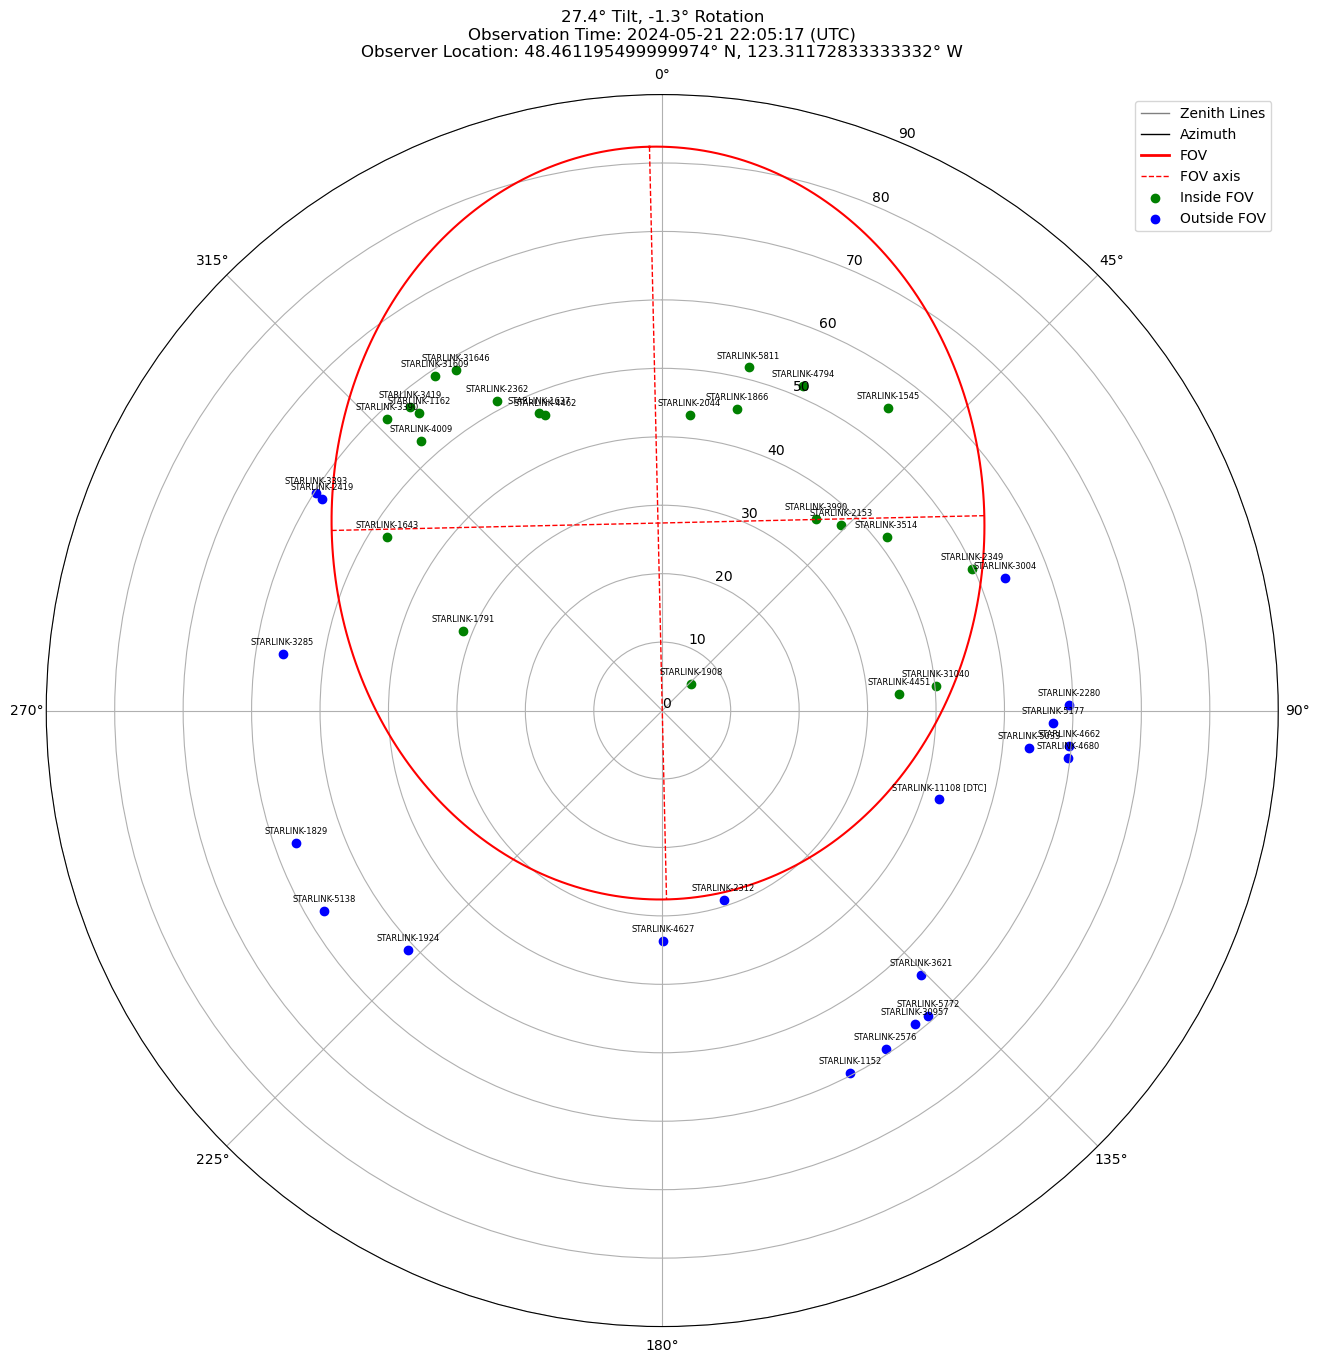

Satellites inside the FOV: ['STARLINK-1162', 'STARLINK-1637', 'STARLINK-1643', 'STARLINK-1545', 'STARLINK-1791', 'STARLINK-1908', 'STARLINK-1866', 'STARLINK-2044', 'STARLINK-2349', 'STARLINK-2362', 'STARLINK-2153', 'STARLINK-3390', 'STARLINK-3419', 'STARLINK-3514', 'STARLINK-4009', 'STARLINK-3990', 'STARLINK-4451', 'STARLINK-4462', 'STARLINK-4794', 'STARLINK-5811', 'STARLINK-31040', 'STARLINK-31646', 'STARLINK-31609']


In [44]:
from skyfield.api import load, wgs84, Topos
import matplotlib.pyplot as plt
import numpy as np
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions(satellites, observer_location, observation_time):
    locations = []
    sats = []
    min_elevation = 30
    for satellite in satellites:
        difference = satellite - observer_location
        topocentric = difference.at(observation_time)
        alt, az, distance = topocentric.altaz()
        if alt.degrees > min_elevation:
            loc = [(90 - alt.degrees, np.radians(az.degrees))]
            locations.append(loc)
            sats.append(satellite)
            print(f"{satellite} at Azimuth: {az.degrees}°, Altitude: {alt.degrees}°, Distance: {distance.km} km")
    return locations, sats

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, locations, sats, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 55
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellites
    for loc, sat in zip(locations, sats):
        loc = np.array(loc)
        r = loc[:, 0]
        angle = loc[:, 1]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        if inside:
            ax.scatter(angle, r, color="g", label="Inside FOV")
            inside_fov.append(sat.name)
        else:
            ax.scatter(angle, r, color="b", label="Outside FOV")
        ax.annotate(sat.name, xy=(angle, r), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')
    
    plt.show()
    print("Satellites inside the FOV:", inside_fov)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time(2024, 5, 21, 22, 5, 17   )
    observer_location = Topos(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=78)
    locations, sats = calculate_satellite_positions(satellites, observer_location, initial_time)
    draw_fov(27.4, -1.3, locations, sats, initial_time, observer_location)
    # draw_fov(10, 45, locations, sats, initial_time, observer_location)
    # draw_fov(20, 90, locations, sats, initial_time, observer_location)
    # draw_fov(30, 315, locations, sats, initial_time, observer_location)
